In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score


In [ ]:
# Load train/validation/test splits created earlier
train_df = pd.read_csv("combined_train.csv")
val_df   = pd.read_csv("combined_val.csv")
test_df  = pd.read_csv("combined_test.csv")

train_df.head()

# Specify which columns contain the text features and labels
TEXT_COL  = "text"
LABEL_COL = "label"

In [ ]:
# Split DataFrames into inputs (X) and labels (y)
X_train, y_train = train_df[TEXT_COL].astype(str), train_df[LABEL_COL].astype(int)
X_val,   y_val   = val_df[TEXT_COL].astype(str),   val_df[LABEL_COL].astype(int)
X_test,  y_test  = test_df[TEXT_COL].astype(str),  test_df[LABEL_COL].astype(int)

# Bag-of-Words vectorizer:
#  - max 5000 features
#  - unigrams + bigrams
#  - remove English stopwords
vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)  
rf = RandomForestClassifier(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1)

In [ ]:
# Unified evaluation function:
#   - Fits model
#   - Predicts on validation + test sets
#   - Prints metrics & confusion matrices
def evaluate(model, Xtr, ytr, Xv, yv, Xte, yte, name):
    model.fit(Xtr, ytr)

    pred_val = model.predict(Xv)
    pred_test = model.predict(Xte)

    print(f"\n=== {name} — Validation ===")
    print("Accuracy:", accuracy_score(yv, pred_val))
    print(classification_report(yv, pred_val, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(yv, pred_val))

    print(f"\n=== {name} — Test ===")
    print("Accuracy:", accuracy_score(yte, pred_test))
    print(classification_report(yte, pred_test, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(yte, pred_test))

In [5]:
evaluate(log_reg, X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Logistic Regression")
evaluate(rf, X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Random Forest")



=== Logistic Regression — Validation ===
Accuracy: 0.8874174851070681
              precision    recall  f1-score   support

           0     0.8534    0.9347    0.8922     12385
           1     0.9283    0.8404    0.8822     12459

    accuracy                         0.8874     24844
   macro avg     0.8909    0.8876    0.8872     24844
weighted avg     0.8910    0.8874    0.8872     24844

Confusion Matrix:
 [[11576   809]
 [ 1988 10471]]

=== Logistic Regression — Test ===
Accuracy: 0.8871357269360811
              precision    recall  f1-score   support

           0     0.8563    0.9297    0.8915     12386
           1     0.9236    0.8448    0.8825     12458

    accuracy                         0.8871     24844
   macro avg     0.8899    0.8873    0.8870     24844
weighted avg     0.8900    0.8871    0.8869     24844

Confusion Matrix:
 [[11515   871]
 [ 1933 10525]]

=== Random Forest — Validation ===
Accuracy: 0.8548140396071486
              precision    recall  f1-score  

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc":"accuracy", "prec":"precision", "rec":"recall", "f1":"f1"}

# Logistic Regression CV
pipe_lr = Pipeline([
    ("bow", CountVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])
cv_lr = cross_validate(pipe_lr, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("\n=== Logistic Regression 5-Fold CV Results ===")
print({m: np.mean(v) for m, v in cv_lr.items() if "test" in m})

# Random Forest CV
pipe_rf = Pipeline([
    ("bow", CountVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))
])
cv_rf = cross_validate(pipe_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

print("\n=== Random Forest 5-Fold CV Results ===")
print({m: np.mean(v) for m, v in cv_rf.items() if "test" in m})


=== Logistic Regression 5-Fold CV Results ===
{'test_acc': np.float64(0.8859667259854327), 'test_prec': np.float64(0.9232879116336669), 'test_rec': np.float64(0.8426174660128991), 'test_f1': np.float64(0.8811076104459928)}

=== Random Forest 5-Fold CV Results ===
{'test_acc': np.float64(0.8531413926793142), 'test_prec': np.float64(0.8330127379406648), 'test_rec': np.float64(0.8844463396040828), 'test_f1': np.float64(0.8579590643150322)}


In [ ]:
# Generate model confidence scores for ROC analysis
def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        # As a last resort (not ideal for ROC); convert predictions to {0,1}
        return model.predict(X)

# Scores
lr_val_scores  = get_scores(log_reg, X_val_vec)
lr_test_scores = get_scores(log_reg, X_test_vec)

rf_val_scores  = get_scores(rf, X_val_vec)
rf_test_scores = get_scores(rf, X_test_vec)

# AUCs
lr_val_auc  = roc_auc_score(y_val,  lr_val_scores)
lr_test_auc = roc_auc_score(y_test, lr_test_scores)
rf_val_auc  = roc_auc_score(y_val,  rf_val_scores)
rf_test_auc = roc_auc_score(y_test, rf_test_scores)

print(f"Logistic Regression AUC — Val:  {lr_val_auc:.4f} | Test: {lr_test_auc:.4f}")
print(f"Random Forest      AUC — Val:  {rf_val_auc:.4f} | Test: {rf_test_auc:.4f}")

Logistic Regression AUC — Val:  0.9453 | Test: 0.9427
Random Forest      AUC — Val:  0.9182 | Test: 0.9156


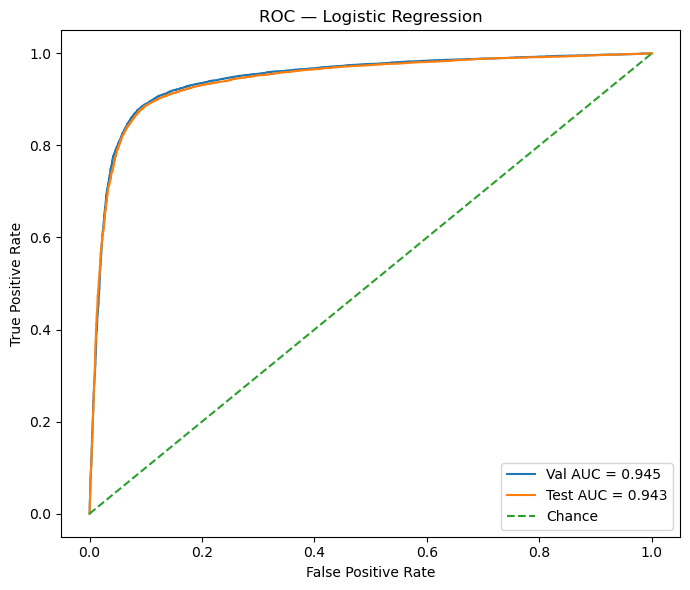

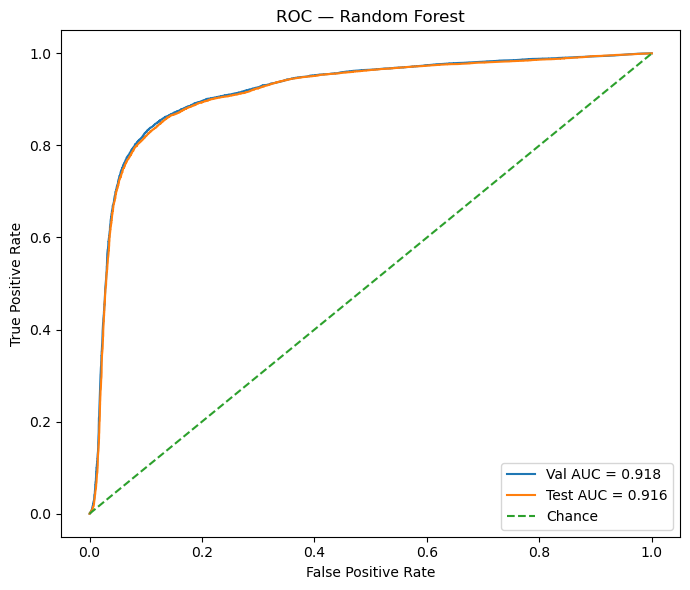


=== Logistic Regression — Test @ 0.5 ===
Accuracy: 0.8871357269360811
              precision    recall  f1-score   support

           0     0.8563    0.9297    0.8915     12386
           1     0.9236    0.8448    0.8825     12458

    accuracy                         0.8871     24844
   macro avg     0.8899    0.8873    0.8870     24844
weighted avg     0.8900    0.8871    0.8869     24844


=== Random Forest — Test @ 0.5 ===
Accuracy: 0.8525197230719691
              precision    recall  f1-score   support

           0     0.8752    0.8213    0.8474     12386
           1     0.8326    0.8835    0.8573     12458

    accuracy                         0.8525     24844
   macro avg     0.8539    0.8524    0.8524     24844
weighted avg     0.8538    0.8525    0.8524     24844



In [ ]:
# ROC Curve — Logistic Regression
fpr_lr_val,  tpr_lr_val,  _ = roc_curve(y_val,  lr_val_scores)
fpr_lr_test, tpr_lr_test, _ = roc_curve(y_test, lr_test_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr_lr_val,  tpr_lr_val,  label=f"Val AUC = {lr_val_auc:.3f}")
plt.plot(fpr_lr_test, tpr_lr_test, label=f"Test AUC = {lr_test_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.title("ROC — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Figure 2: Random Forest (Val + Test)
fpr_rf_val,  tpr_rf_val,  _ = roc_curve(y_val,  rf_val_scores)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, rf_test_scores)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rf_val,  tpr_rf_val,  label=f"Val AUC = {rf_val_auc:.3f}")
plt.plot(fpr_rf_test, tpr_rf_test, label=f"Test AUC = {rf_test_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--", label="Chance")
plt.title("ROC — Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

lr_test_pred = (lr_test_scores >= 0.5).astype(int)
rf_test_pred = (rf_test_scores >= 0.5).astype(int)

print("\n=== Logistic Regression — Test @ 0.5 ===")
print("Accuracy:", accuracy_score(y_test, lr_test_pred))
print(classification_report(y_test, lr_test_pred, digits=4))

print("\n=== Random Forest — Test @ 0.5 ===")
print("Accuracy:", accuracy_score(y_test, rf_test_pred))
print(classification_report(y_test, rf_test_pred, digits=4))

In [ ]:
# Manual 5-fold ROC visualization for Logistic Regression
X = X_train
y = y_train


vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)
vectorizer.fit(X)

# Create stratified folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))

fold = 1

# Iterate through folds
for train_idx, test_idx in cv.split(X, y):

    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # BOW features
    X_tr_bow = vectorizer.transform(X_tr)
    X_te_bow = vectorizer.transform(X_te)

    # Model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_tr_bow, y_tr)

    # Prediction probabilities for ROC
    y_prob = clf.predict_proba(X_te_bow)[:, 1]
    y_pred = clf.predict(X_te_bow)
    
    # ROC values
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    fold_auc = aucs(fpr, tpr)
    aucs.append(fold_auc)

    # interpolate TPR for mean curve calculation
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    # Plot each fold
    plt.plot(fpr, tpr, lw=1.5, alpha=0.5, label=f"Fold {fold} (AUC = {fold_auc:.3f})")
    
    print(f"\n====================== Fold {fold} ======================")
    print(f"AUC: {fold_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_te, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_te, y_pred))
    
    fold += 1


mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(
    mean_fpr, mean_tpr,
    color="black",
    linestyle="--",
    label=f"Mean ROC (AUC = {mean_auc:.3f})",
    linewidth=2.5
)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")

plt.title("5-Fold Cross-Validated ROC Curves\n(Logistic Regression + Bag-of-Words)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean AUC across folds: {mean_auc:.4f}")


NameError: name 'auc' is not defined

<Figure size 800x600 with 0 Axes>